# Identifying Persons of Interest in the Enron Fraud

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

This project will be used to build a person of interest identifier (POI) based on financial and email data made public as a result of the Enron scandal. To assist with this I will be using a hand-generated list of persons of interest in the fraud case, which includes individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. 

The Enron email and financial data have been combined into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

In [1]:
import sys
import pickle
sys.path.append("/tools/")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)
df = pd.DataFrame.from_dict(enron_data, orient='index')

## Explore the data set
We'll start off by briefly explore the data set to find out what type of values we're dealing with, if there's a lot of missing values etc. 

In [3]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [4]:
print 'Number of features:', len(df.columns)
print 'Total number of people:', df['poi'].count()
print 'Number of POIs in data set:', df.loc[df.poi == True, 'poi'].count()

count = 0
with open('poi_names.txt', 'r') as f:
    for line in f:
        if '(y)' in line or '(n)' in line:
            count += 1
print "Number of POI in poi_names.txt:", count

Number of features: 21
Total number of people: 146
Number of POIs in data set: 18
Number of POI in poi_names.txt: 35


In [5]:
# How many people in this dataset have a quantified salary, known email address or NaN payments?

print "The number of quantified salaries is:", (df['salary'] !='NaN').sum()
print "The total number of given email addresses is:", (df['email_address'] !='NaN').sum()
print "The number of NaN payments is:", (df['total_payments'] =='NaN').sum()

The number of quantified salaries is: 95
The total number of given email addresses is: 111
The number of NaN payments is: 21


The NaN's found in the financial data could be interpreted as 0. Looking at the insider pay document we can see that some employees have 0 listed for their bonus. Therefore I will replace the NaNs in the financial data with 0s. 

In [6]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
df = df.replace('NaN', np.nan)
df[financial_features] = df[financial_features].fillna(0)

We will also neeed to fill in NaN for email features as well. I will fill in the missing values with the median of the columns.

In [7]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
df[email_features] = df[email_features].fillna(df[email_features].median())

In [8]:
#Check to see NaN values have been replaced.
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,41.0,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,0.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,0.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0


## Outliers

I'll examine the financial features to see if there are any outliers.

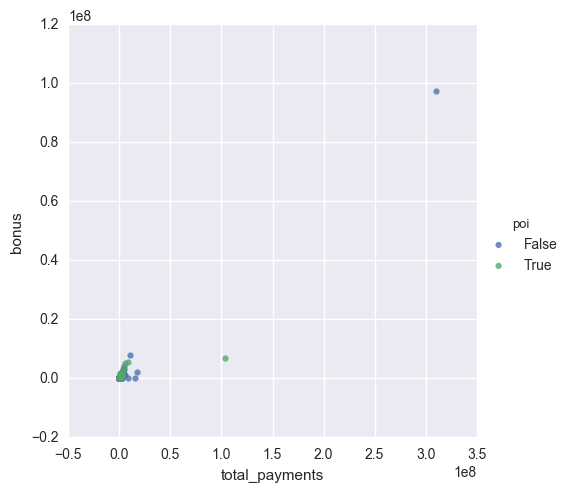

In [9]:
sns.lmplot('total_payments', 'bonus', 
           data=df, 
           fit_reg=False, 
           hue='poi')

There is an obvious outlier in the plot above. After comparing the data point to the salary documents it turns out that this point is the 'TOTAL' value of all the listed salries. Since this doesn't represent anyone in particular it will be manually removed. 

In [10]:
df = df.drop('TOTAL')

After removing this point it looks like there are still some outliers. These other outliers are people with extremely high salaries/bonuses. Even though they look like outliers they are in fact accurate values, many of which correspond to POIs, so they won't be removed. 

##  Creating new features

Two new features will be created: (i) fracion_msgs_to_poi and (ii) fracion_msgs_from_poi. These are the fractions of messages a person sends/receives to/from a POI. These two features are helpful as they measure the proportion of emails that are related to a POI. Someone who sends/receives a lot of emails to/from a POI is more likely to be a POI themselves.

In [11]:
df_new = df.copy()
df_new['fracion_msgs_to_poi'] = df.from_this_person_to_poi / df.from_messages
df_new['fracion_msgs_from_poi'] = df.from_poi_to_this_person / df.to_messages

## Classifying the dataset

We'll split the data set in to a training and testing set. Using StratifiedShuffleSplit returns stratified randomized folds. Since the data set we are dealing with is relatively small and unbalanced using StratifiedShuffleSplit to randomly split the dataset, and use the whole dataset for both buidling and assessing the model should lead to a more stable evaluation. 

In [14]:
data = df.drop(['poi', 'email_address'], axis=1)
X = data.values
y = df.poi

In [15]:
# Generate the training and testing data
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

('TRAIN:', array([ 65,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144]), 'TEST:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68,
       69, 70, 71, 72, 73]))
('TRAIN:', array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 

## Feature reduction

The aim of feature reduction is to select the best number of top features or reduce dimension of features.

PCA (Principal Component Analysis) uses linear algebra to transform the dataset into a compressed form. I will start off by chosing 2-3 dimensions for PCA.

SelectPercentile 

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)

X_train_pca2 = pca.transform(X_train)
X_test_pca2 = pca.transform(X_test)

pca = PCA(n_components=5)
pca.fit(X_train)

X_train_pca5 = pca.transform(X_train)
X_test_pca5 = pca.transform(X_test)

In [17]:
from sklearn.feature_selection import SelectPercentile

X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train, y_train)
X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test, y_test)

X_train_reduce10 = SelectPercentile().fit_transform(X_train, y_train)
X_test_reduce10 = SelectPercentile().fit_transform(X_test, y_test)

## Testing accuracy of various classifiers

Four algorithms will be tested: AdaBoost, Naive Bayes, Decision tree classifier and Random Forest. For each algorithm, evaluation metrics including accuracy, precision, recall and f1 score will be calculated for a varying number of features from SelectKBest and PCA methods. 

Accuracy, precision, recall and f1 score are used as metrics to evaluate the model performance. 
* Accuracy: True Positive + True Negative / (True Positive + True Negative + False Positive + False Negative). Accuracy measures the percentage of correctly identified POIs and non-POIs from all of the predictions made. Accuracy is a good initial indicator but it can be misleading.
* Precision: True Positive / (True Positive + False Positive). Precision measures how many of the items labeled as positive truely belong to the positive class.
* Recall:  True Positive / (True Positive + False Negative). Recall measure out of all the items that are truely positive, how many were correctly classified as positive. 
* F1 score gives a harmonic mean of precision and recall.

In [21]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from time import time

import warnings

models = {"AdaBoost Classifier": AdaBoostClassifier(), "Gaussian Naive Bayes": GaussianNB(), 
          "Decision Tree Classifier": tree.DecisionTreeClassifier(), "Random Forest Classifier": RandomForestClassifier()} 
          

data = {"": X_train, "(30% of features)": X_train_reduce30, "(10% of features)": X_train_reduce10,
       "(PCA: 2 components)": X_train_pca2, "(PCA: 5 components)": X_train_pca5}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in models.items():
        for scale, X in data.items():
            n = name + " " + scale
            clf = model
            accuracy = cross_val_score(clf, X_train, y_train).mean()
    
            y_pred = cross_val_predict(clf, X_train, y_train)

            rec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
            prec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
            f1 = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()


            res[n] = {"MeanAccuracy": accuracy, "Precision": prec, "Recall": rec, "F1Score": f1}

results = pd.DataFrame.from_dict(res, orient="index")
results = results[["MeanAccuracy", "Precision", "Recall", "F1Score"]]

results

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (10% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (30% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (PCA: 2 components),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (PCA: 5 components),0.779444,0.222222,0.222222,0.222222
Decision Tree Classifier,0.835000,0.666667,0.555556,0.666667
Decision Tree Classifier (10% of features),0.835000,0.666667,0.444444,0.666667
Decision Tree Classifier (30% of features),0.835000,0.666667,0.666667,0.444444
Decision Tree Classifier (PCA: 2 components),0.835000,0.666667,0.444444,0.444444
Decision Tree Classifier (PCA: 5 components),0.835000,0.666667,0.444444,0.444444


A quick note on accuracy: as shown above, accuracy can be a misleading metric. Take a look at the Random Forest Classifier ithout any parameter tuning. It has a relatively high accuracy score of 0.876, but it scored a 0 in both precision and recall! This model is doing nothing but reflecting the distribution of our underlying classes. If we hadn't taken precision and recall into account, we could have missed that. I think that the unbalanced classes could be contributing to the underwhelming initial performance, so parameter tuning will take on an added performance here.

Our best performing classifier in terms of recall was the Gaussian Naive Bayes classifier. With a recall of 77%, this classifier correctly flagged more than half of the POIs in our data. That classifier also had the highest F1 score (the harmonic mean of precision and recall).

Now let's do some parameter tuning, in the hopes that some penalty and class weight parameters might be able to bring up the recall of some other models in a meaningful way.

## Parameter tuning

***** What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? *****

Parameter tuning searches for optimized parameters for a given algorithm. It is an important step because even if a well suited algorithm is used without the correct paarmeters it can perform poorly. In order to acheive the best possible results we can use GridSerchCV to search for the best parameters to use for a given algorithm. 

In [19]:
from sklearn.grid_search import GridSearchCV

default_recall = make_scorer(recall_score, pos_label=0)

param_grid = {"class_weight": ["balanced", {0: 2, 1: 1}, {0: 5, 1: 1}, {0: 10, 1: 1}], 
              "min_samples_split": [2, 3, 5, 10, 20]}

forest = RandomForestClassifier()
clf = GridSearchCV(forest, param_grid=param_grid, scoring=default_recall)

clf.fit(X_train, y_train)

clf.best_params_, clf.best_score_ 

/Users/Sian/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


({'class_weight': {0: 2, 1: 1}, 'min_samples_split': 20}, 1.0)

## Evaluation metrics

What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis? 

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.

## Questions


**4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?**  

**How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).**  


**5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?**

**6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. **



## Files included in this project:
* **poi_id.py :** Code for the POI identifier.
* **final_project_dataset.pkl :** The dataset for the project. 
* **tester.py :** Used to test the functionality of the poi_id.py file. 
* **emails_by_address :** This directory contains many text files, each of which contains all the messages to or from a particular email address. 